Your goal is to build and train a neural network that performs single object localization using the Keras framework and the Oxford Pets dataset. You can leverage much of the code from the Object Localization Jupyter notebook, and you'll have to add and modify some code as well.


---

# **Part 1: Download the data**
You can download the images and annotations for the Oxford Pets dataset from this website [https://www.robots.ox.ac.uk/~vgg/data/pets/](https://www.robots.ox.ac.uk/~vgg/data/pets/). The downloads section is near the top of the page. You will need to download both the "images" and "ground truth" datasets for this exercise.


---
# **Part 2: Parse and prepare the data**
​
The dataset is described extensively on the website, as well as the Object Localization notebook in this same folder. Additionally, the notebook contains Python code that parses the raw data into a format that is ready for Keras to process. For each image you should:
1. Extract the image data and turn it into a Numpy array.
1. Ensure the image is square by padding it appropriately with black pixels.
1. Scale the image to an appropriate size as determined by the neural network you import (e.g. Xception, MobileNetV2, etc.)
1. Extract the bounding box from the XML file associated with each image.
1. Appropriately adjust the bounding box for any padding and resizing that the image received.
1. Extract the classification labels for each image.
1. Ignore images that do not have a bounding box in the provided annotations.

In [ ]:
# All the imports:
from collections import namedtuple
import csv

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from PIL import Image, ImageOps

# This is new, the XML parsing library comes with Python
import xml.etree.ElementTree as ET

In [ ]:
# First, we have to download and prepare the data. We're using the Oxford Pet dataset
# linked above. You need the "dataset" and the "groundtruth data" listed under Downloads

# Modify these to fit wherever you save the data.
PATH_TO_IMAGES = '/content/drive/MyDrive/images'
PATH_TO_CLASS_LIST = '/content/drive/MyDrive/list.txt'
PATH_TO_XML_ANNOTATIONS = '/content/drive/MyDrive/xmls'

# Change if you wish.
TARGET_SIZE = (224, 224)

In [ ]:
# Just to make the code a bit easier to read.
BoundingBox = namedtuple('BoundingBox', 'xmin ymin xmax ymax')

# A function to read the XML and return (xmin, ymin, xmax, ymax)
def get_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()

    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)

    return BoundingBox(xmin, ymin, xmax, ymax)

In [ ]:
# A function to reshape the images and appropriately transform
# the bounding box for that image. Much of this comes from last lab
# and should look familiar.
def resize_image_with_bounds(path_to_image, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size

    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0

    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0

    # When we pad the image to square, we have to adjust all the bounding box
    # values by the amounts we added on the left or top. The "bonus" pads are
    # always done on the bottom and right so we can ignore them in terms of the box.
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))

    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad

    # When we resize the image, it's by some scalar. We have to apply that
    # scalar to the bounding box as well. We may lose a small amount of precision
    # when we do this, but not so much that it'll hurt our predictions
    if target_size is not None:
        # Note, width and height have changed due to the padding resize.
        # Update our notions so we get the scale factor right
        width, height = image.size

        image = image.resize(target_size)

        width_scale = target_size[0] / width
        height_scale = target_size[1] / height

        if bounding_box is not None:
            new_xmin = new_xmin * width_scale
            new_xmax = new_xmax * width_scale
            new_ymin = new_ymin * height_scale
            new_ymax = new_ymax * height_scale

    image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)

    # Image data is a 3D array, 3 channels (RGB) of target_size.
    # RBG values are from 0-255. Later in this notebook we preprocess
    # those images with the MobileNetV2 preprocess input function.
    if bounding_box is None:
        return image_data, None

    return (image_data, BoundingBox(new_xmin, new_ymin, new_xmax, new_ymax))

In [ ]:
# Given the relevant data from a row of the CSV return a reshaped image
# as well as it's transformed bounding box
def prepare_sample_from_name(sample_name):
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    path_to_xml = os.path.join(PATH_TO_XML_ANNOTATIONS, sample_name + '.xml')

    original_bounding_box = get_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, TARGET_SIZE)

    return (image_data, bounding_box)

In [ ]:
# Given the image data, plot the data with the bounding box.
# for testing/verification purposes.
def plot_with_box(image_data, bounding_box, compare_box=None):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image_data)

    # Create a Rectangle patch.
    rect_red = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
                             bounding_box.xmax - bounding_box.xmin,
                             bounding_box.ymax - bounding_box.ymin,
                             linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect_red)

    if compare_box is not None:
        rect_blue = patches.Rectangle((compare_box.xmin, compare_box.ymin),
                             compare_box.xmax - compare_box.xmin,
                             compare_box.ymax - compare_box.ymin,
                             linewidth=2, edgecolor='b', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect_blue)

    plt.show()

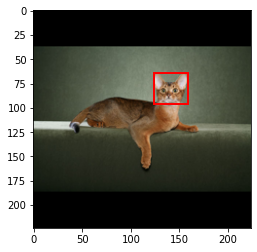

In [ ]:
# Lets take a look at what we've done:
sample_name = 'Abyssinian_1'

image, bounding_box = prepare_sample_from_name(sample_name)
plot_with_box(image, bounding_box)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Part 3: Import and prepare a CNN**
​
Like in previous labs and exercises, we're applying transfer learning. Import a pre-trained network from Keras with `include_top=False`. Then, using the Keras functional API, give that network two prediction heads: one for classification and one for object localization.
​
You'll have to decide which loss functions to use, and how to weight the predictions from each head during training at this point as well. In the notebook we used `binary_crossentropy` for the classifier, and `mse` for the localizer with weights of `1` and `800` respectively (those weights were chosen arbitrarily, but worked decently). You may wish to experiment with other options.


In [ ]:
# Okay, lets get all our samples processed. After this we'll prepare the
# data and labels for our network and perform a validation split.
processed_data = []

# Processing all this data takes some time...
# Took my laptop roughly 5 minutes
with open(PATH_TO_CLASS_LIST) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')

    for row in csv_reader:
        if row[0].startswith('#'): continue

        # Unpack for readability
        sample_name, class_id, species, breed_id = row

        # Not every image has a bounding box, some files are missing.
        # Use a try/except block to ignore such samples
        try:
            image, bounding_box = prepare_sample_from_name(sample_name)
        except FileNotFoundError:
            # This actually happens quite a lot, as you can see in the output.
            # we end up with 7349 samples.
            print(f'No annotations for {sample_name}: skipped.')
            continue

        # species - 1 so cat = 0 and dog = 1.
        # Makes things a little easier to process
        data_tuple = (image, int(species) - 1, bounding_box)
        processed_data.append(data_tuple)

print(f'Processed {len(processed_data)} samples')

# Make it a numpy array
processed_data = np.array(processed_data)

No annotations for Abyssinian_104: skipped.
No annotations for Bengal_111: skipped.
No annotations for samoyed_10: skipped.
No annotations for Bengal_175: skipped.
No annotations for Egyptian_Mau_14: skipped.
No annotations for Egyptian_Mau_156: skipped.
No annotations for Egyptian_Mau_186: skipped.
No annotations for Ragdoll_199: skipped.
No annotations for saint_bernard_15: skipped.
No annotations for Abyssinian_201: skipped.
No annotations for Abyssinian_202: skipped.
No annotations for Abyssinian_204: skipped.
No annotations for Abyssinian_205: skipped.
No annotations for Abyssinian_206: skipped.
No annotations for Abyssinian_207: skipped.
No annotations for Abyssinian_20: skipped.
No annotations for Abyssinian_210: skipped.
No annotations for Abyssinian_212: skipped.
No annotations for Abyssinian_213: skipped.
No annotations for Abyssinian_215: skipped.
No annotations for Abyssinian_216: skipped.
No annotations for Abyssinian_217: skipped.
No annotations for Abyssinian_219: skippe

1437 dog


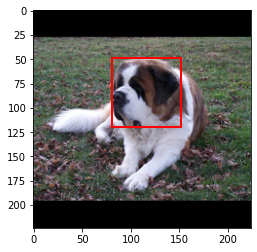

627 dog


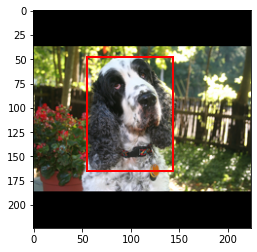

3122 dog


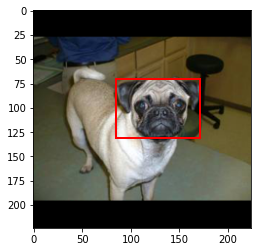

3076 dog


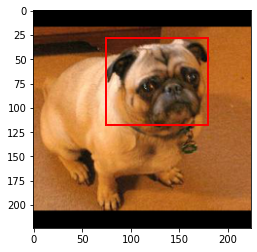

2999 cat


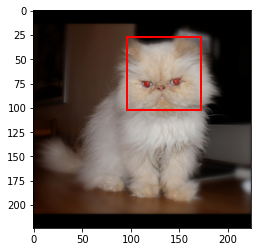

In [ ]:
# Lets just do some random spot checking
for _ in range(5):
    i = np.random.randint(len(processed_data))
    image, species, bounding_box = processed_data[i]

    if species == 0:
        print(i, "cat")
    elif species == 1:
        print(i, "dog")
    else:
        print("ERROR DETECTED: Invalid species type")

    plot_with_box(image, bounding_box)

In [ ]:
# We still have to split our data. We also have to create TWO separate
# label groups, since we're going to handle the classificaton and
# bounding box predictions separately.
x_train = []
y_class_train = []
y_box_train = []

x_validation = []
y_class_validation = []
y_box_validation = []

validation_split = 0.2

# Notice that we're applying the preprocess_input function here:
for image, species, bounding_box in processed_data:
    if np.random.random() > validation_split:
        x_train.append(preprocess_input(image))
        y_class_train.append(species)
        y_box_train.append(bounding_box)
    else:
        x_validation.append(preprocess_input(image))
        y_class_validation.append(species)
        y_box_validation.append(bounding_box)

x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)

x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

# **Part 4: Train and evaluate the model**
​
Training the model may take a long time, particularly if you'd like to do several epochs. Once you've trained the network evaluate its performance by looking at the loss and accuracy metrics, as well as looking at several of your networks predictions. Code for visualizing the networks predicted bounding boxes and the ground truth from in the dataset is provided in the Object Localization Jupyter notebook.

In [ ]:
# We don't have a TON of data. It's also much harder to use image augmentation
# since we'd have to apply the transformation to the bounding box data as well
# Lets still use transfer learning
# Like before, we grab a pretrained model with include_top=False
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# We're going to lop off the last few layers, which have most
# likely learned the highest level features specific to imagenet
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])

# Now, we're actually going to produce two outputs.
# One to learn "cat" vs "dog" and another to learn the bounding box.
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)

localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)

model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________

In [ ]:
# okay, now when we compile the model we have to provide it with two loss functions
# one for each output layer.

model.compile(
    optimizer='adam', metrics=['accuracy'],
    loss=['binary_crossentropy', 'mse'],
    loss_weights=[800, 1]  # The MSE loss is goign to be much larger than the binary_cross_entropy.
                           # so we're weighting it up to ensure the network learns to box *and* classify
)

model.fit(x_train, [y_class_train, y_box_train],
          validation_data=(x_validation, [y_class_validation, y_box_validation]),
          epochs=3,
          verbose=True
)

Epoch 1/3
92/92 [==============================] - 450s 5s/step - loss: 1151.0873 - dense_loss: 0.3772 - dense_1_loss: 849.3184 - dense_accuracy: 0.8296 - dense_1_accuracy: 0.7912 - val_loss: 2446.7612 - val_dense_loss: 2.2914 - val_dense_1_loss: 613.6788 - val_dense_accuracy: 0.6785 - val_dense_1_accuracy: 0.8249
Epoch 2/3
92/92 [==============================] - 451s 5s/step - loss: 327.5933 - dense_loss: 0.1221 - dense_1_loss: 229.8901 - dense_accuracy: 0.9561 - dense_1_accuracy: 0.8636 - val_loss: 3081.4258 - val_dense_loss: 3.3567 - val_dense_1_loss: 396.0829 - val_dense_accuracy: 0.6772 - val_dense_1_accuracy: 0.8057
Epoch 3/3
92/92 [==============================] - 447s 5s/step - loss: 190.4446 - dense_loss: 0.0551 - dense_1_loss: 146.3443 - dense_accuracy: 0.9840 - dense_1_accuracy: 0.8854 - val_loss: 1424.7770 - val_dense_loss: 1.3335 - val_dense_1_loss: 357.9836 - val_dense_accuracy: 0.7278 - val_dense_1_accuracy: 0.8372


Called it a dog


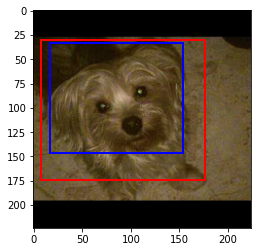

Called it a dog


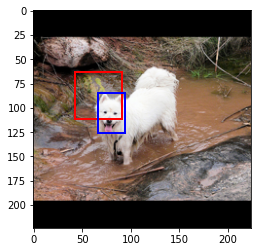

Called it a dog


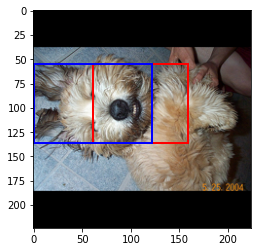

Called it a dog


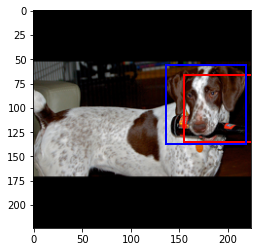

Called it a dog


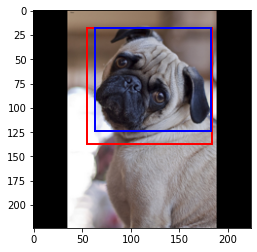

Called it a dog


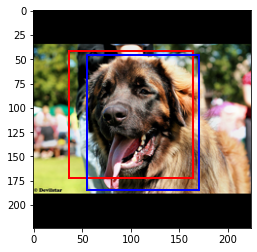

Called it a dog


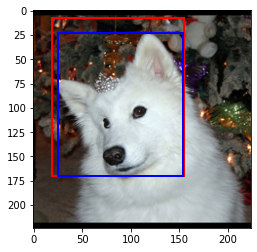

Called it a dog


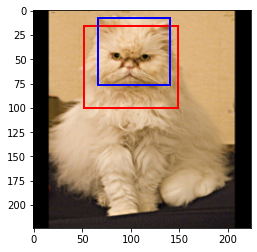

Called it a dog


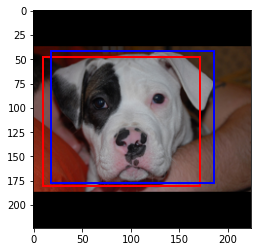

Called it a dog


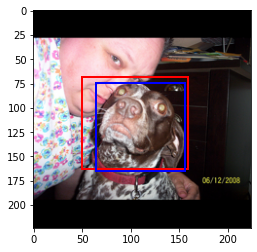

Called it a dog


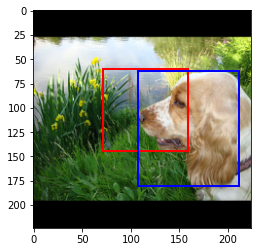

Called it a dog


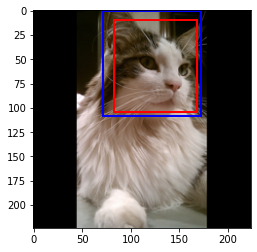

Called it a dog


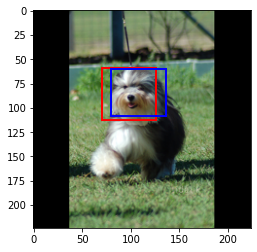

Called it a dog


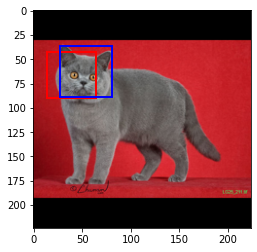

Called it a dog


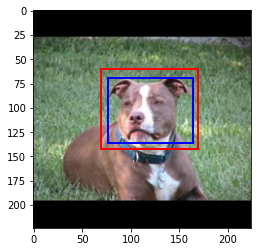

Called it a dog


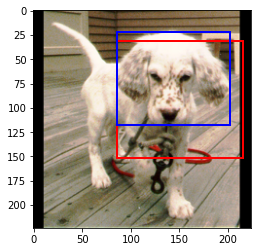

Called it a dog


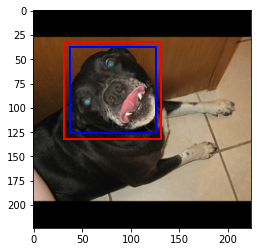

Called it a dog


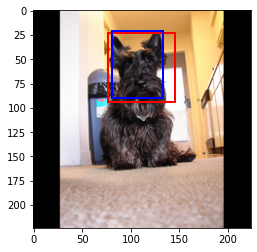

Called it a dog


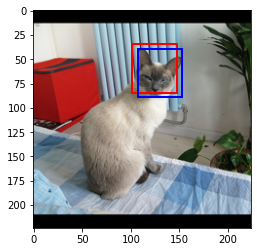

Called it a dog


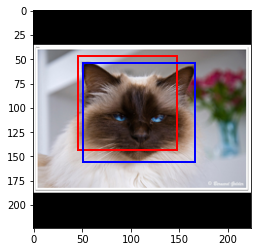

In [ ]:
# Fetching the non mobile-net processed images so we can actually see them
for _ in range(20):
    i = np.random.randint(len(processed_data))
    img, species, true_bounding_box = processed_data[i]

    pred = model.predict(np.array([preprocess_input(img)]))

    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")


    # Thre true box is in blue, predicted in red
    plot_with_box(img, BoundingBox(*pred[1][0]), true_bounding_box)

/content/drive/MyDrive/images/Ragdoll_199.jpg
Called it a dog


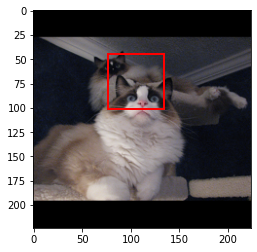

/content/drive/MyDrive/images/saint_bernard_15.jpg
Called it a dog


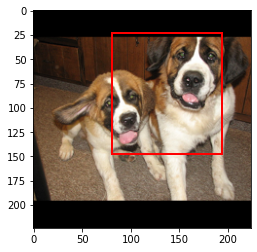

/content/drive/MyDrive/images/Abyssinian_201.jpg
Called it a dog


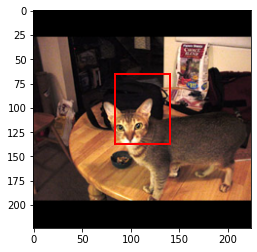

/content/drive/MyDrive/images/american_bulldog_35.jpg
Called it a dog


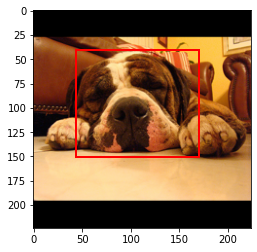

/content/drive/MyDrive/images/american_pit_bull_terrier_191.jpg
Called it a dog


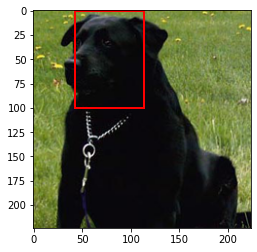

/content/drive/MyDrive/images/basset_hound_200.jpg
Called it a dog


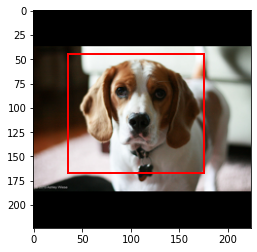

/content/drive/MyDrive/images/beagle_202.jpg
Called it a dog


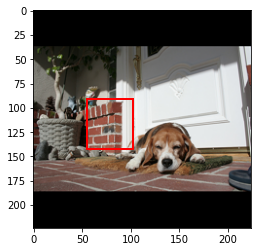

In [ ]:
# Lets see how it does on some images that we didn't have the bounding boxes for
# so haven't been part of validation or training data!

unknown_samples = [
    'Ragdoll_199',
    'saint_bernard_15',
    'Abyssinian_201',
    'american_bulldog_35',
    'american_pit_bull_terrier_191',
    'basset_hound_200',
    'beagle_202'
]

for sample_name in unknown_samples:
    path_to_image = os.path.join(PATH_TO_IMAGES, sample_name + '.jpg')
    print(path_to_image)
    img, _ = resize_image_with_bounds(path_to_image, target_size=TARGET_SIZE)
    pred = model.predict(np.array([preprocess_input(img)]))

    if pred[0][0] < .5:
        print("Called it a Cat")
    else:
        print("Called it a dog")


    # We have no idea what the "true bounding box" should be
    # but we can decide if we think our network is doing okay
    plot_with_box(img, BoundingBox(*pred[1][0]))
